In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
import cloudpickle
from comparers import ModelComparer
from tasks.boston_housing import make_task3 as make_task
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
clf_a, clf_b, X, y, feature_names = make_task()
comparer = ModelComparer(clf_a, clf_b, feature_names)

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


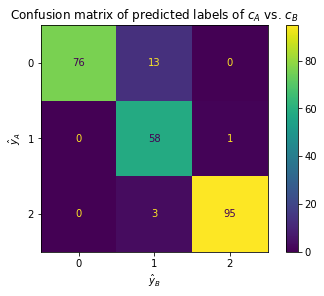

In [3]:
comparer.plot_confusion_matrix(X)